<a href="https://colab.research.google.com/github/lorenzflow/FunctionalDeepLearning/blob/main/VAE_Basis_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing different basis for the VAE on Hilbert Spaces




##Load Drive

In [1]:
# connect drive to save models after training
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Imports and Installations

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping

from sklearn import gaussian_process

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_kernels
import scipy.linalg as lin
from scipy.special import zeta
from sklearn.decomposition import PCA
import sklearn.gaussian_process as gp
from scipy.stats import t
from scipy.stats import percentileofscore 
import os
import random
from matplotlib import image
from sklearn.manifold import TSNE

!pip install pycwt
import pycwt
import pywt

     |████████████████████████████████| 758 kB 6.1 MB/s 
  Created wheel for pycwt: filename=pycwt-0.3.0a22-py3-none-any.whl size=17824 sha256=53dab81bb3d26b9732ed1b37da9444af6fc1d0079f22bc1d90973a065bc76163
  Stored in directory: /root/.cache/pip/wheels/53/99/6b/a43c99414482c20862ca8917862237de8bd27ee795a55faa6c
Successfully built pycwt


## Sampling from GP to generate train and test data and other synthetic methods

In [3]:

GP = gaussian_process.GaussianProcessRegressor(optimizer='fmin_l_bfgs_b', 
                              n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)



In [ ]:
x = np.random.uniform(-2,2,100)
y = x**3 + np.random.normal(size=(100))

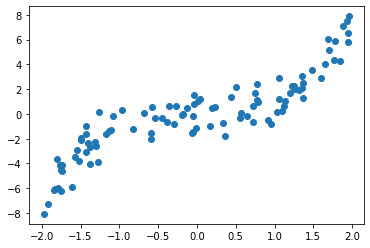

In [ ]:
plt.scatter(x,y)

In [ ]:
GP.fit(x.reshape(-1, 1),y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [ ]:
test_x, test_y = sample_batch(100, 100, GP, -2, 2, x=1)

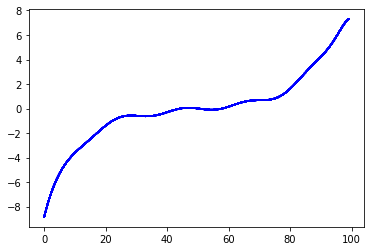

In [ ]:
dum = plt.plot(np.transpose(test_y), color='blue', alpha=0.5)

In [4]:
def sample_batch(batch_size, num_points, GP, lower, upper, x=None):
  if x==None:
    X = np.random.uniform(lower, upper, (batch_size,num_points))
    Y = np.zeros_like(X)
    for i in range(batch_size):
      Y[i,:] = np.squeeze(GP.sample_y(X[i,:].reshape(-1, 1)))
    return np.expand_dims(X,-1),np.expand_dims(Y,-1)
  else: # num_ points equally spaced points between lower and upper
    x = np.linspace(lower, upper, num_points)
    #for i in range(batch_size):
    Y = GP.sample_y(x[:, np.newaxis], batch_size)
    return x, np.transpose(Y)

Text(0, 0.5, 'y')

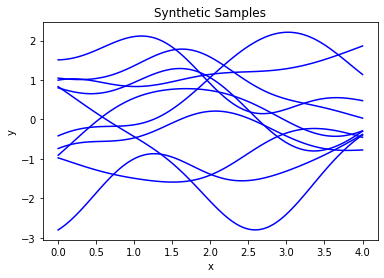

In [12]:
sample_vis = sample_batch(10, 100, GP, 0, 4, x=1)
gugu = plt.plot(np.linspace(0,4,100), np.transpose(sample_vis[1]), color='blue')
plt.title('Synthetic Samples')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
def generate_AR(sigma, alpha, num_samples, num_points):
  noise = np.random.normal(scale = sigma, size = (num_samples, num_points))
  Samples = np.zeros((num_samples, num_points))
  Samples[:,0] = noise[:,0]

  for i in range(1,num_points):
    Samples[:,i] = alpha * Samples[:,i-1] + noise[:,i]
  return Samples

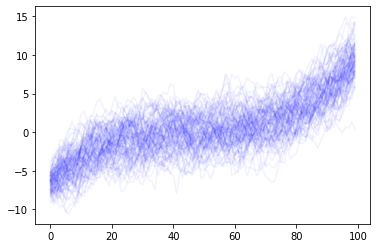

In [ ]:
Samples = generate_AR(1, 0.9, 100, 100) + np.linspace(-2,2, 100)**3 + 0.4 * np.linspace(-2,2, 100)**2
tell = plt.plot(np.transpose(Samples), alpha = 0.05, color='blue')

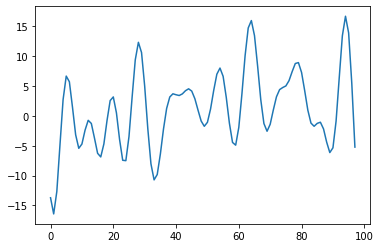

In [ ]:
coeffs = np.zeros(50) + 0j
coeffs[:15] = (np.random.normal(size=(15)) + 1j * np.random.normal(size=(15)))
sample = np.fft.irfft(coeffs)
plt.plot(sample * 100)

In [ ]:
samples = sample * 50 + np.random.normal(scale = 1, size=(100,98))

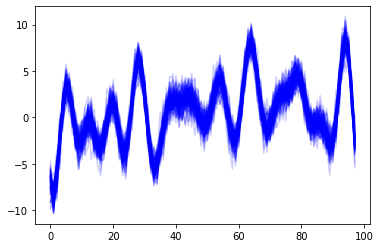

In [ ]:
keep_it_going = plt.plot(np.transpose(samples), alpha=0.2, color='blue')

## Standard VAE class

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    """Signature input to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=10, intermediate_dim=40, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = Dense(intermediate_dim, activation="relu")
        self.dense_mean = Dense(latent_dim)
        self.dense_log_var = Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded signature vector, back into a signature."""

    def __init__(self, original_dim, intermediate_dim=40, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = Dense(intermediate_dim, activation="relu")
        self.dense_output = Dense(original_dim)

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)
        #self.mean_list = []
        #self.log_var_list = []

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

### Some helper functions for visualising VAE results

In [ ]:
 def reconstruct(vae, fourier_data, num_reconstructed, original_length_of_FFT,tf_prob=False, normalise_fourier=1, normalise_path=1):
  if num_reconstructed==None:
    num_reconstructed = fourier_data.shape[1]
  if tf_prob:
    vae_output = vae(fourier_data[:num_reconstructed,:]).mean()
  else:
    vae_output = vae(fourier_data[:num_reconstructed,:])
  # half of the values corresponds to real and other half to complex coefficients  
  reconstructed = invert_fourier(vae_output, original_length_of_FFT, normalise_fourier, normalise_path)
  return reconstructed

def plot_vae_reconstructions(reconstructed, original):
  
  # View the reconstructions and original
  n_rows, n_cols = 2, 4

  fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
  for i, ax in enumerate(fig.axes):
     
      X = np.linspace(0,1, len(original[i,:]))
      X_ = np.linspace(0,1, len(reconstructed[i,:]))

      #ax.set_ylabel(str(i))
      ax.plot(X, original[i,:], color='blue', label='original')
      ax.plot(X_, reconstructed[i,:], color='red', label='reconstructed')
      #ax.set_ylim([-15,15])
      #if i!=0 and i!=5 and i!=10:
      #  ax.get_yaxis().set_visible(False)
      if i<10:
        ax.get_xaxis().set_visible(False)
      if i ==3:
        ax.legend(loc='upper right')
  fig.suptitle('Original and FFT-VAE Reconstructions')
  plt.show()

In [ ]:

def sample_vae(decoder, prior, num_samples, original_length_of_FFT, latent_size, tf_prob=False, normalise_fourier=1, normalise_path=1):

  if prior==None:
    import tensorflow_probability as tfp
    tfd = tfp.distributions
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)
  if tf_prob:
    fourier_samples= decoder(prior.sample(num_samples)).mean()
  else:
    fourier_samples= decoder(prior.sample(num_samples))

  path_samples = invert_fourier(fourier_samples, original_length_of_FFT, normalise_fourier, normalise_path)

  return path_samples

def plot_samples_v_original(original, decoder, prior, num_samples, original_length_of_FFT, latent_size, tf_prob=False, normalise_fourier=1, normalise_path=1):

  samples = sample_vae(decoder, prior, num_samples, original_length_of_FFT, latent_size, tf_prob, normalise_fourier, normalise_path)

  fig, axs = plt.subplots(1, 2, figsize=(14, 5))
  y_upper = np.max([np.max(samples), np.max(original)])
  y_lower = np.min([np.min(samples), np.min(original)])
  for i in range(0,num_samples):
    X_l = np.linspace(0,1259, len(original[i,:]))
    X_f = np.linspace(0,1259, samples.shape[1])
    axs[0].plot(X_f,samples[i,:], color='blue', alpha=0.2)
    axs[1].plot(X_l, original[i,:], color='blue', alpha=0.2)
    axs[0].set_ylim([y_lower,y_upper])
    axs[1].set_ylim([y_lower,y_upper])
  axs[0].set_title('FVAE samples')
  axs[1].set_title('Original Data')
  plt.show()

## Code for Kernels and MMD for discriminative comparison

In [6]:
# This kernel allows comparison in mean and variance
def K_SQR(X,Y,gamma = 1):
    """
    Forms the kernel matrix K for the two sample test using the SE-T kernel with bandwidth gamma
    where T is the map which sends x -> (x,x^{2}) in the Cartesian product of L^{2} with itself.
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel to be used on the two norms, if -1 then median heuristic 
            is used to pick a different gamma for each norm, if gamma = 0 then median heuristic
            is used to pick a single gamma for each norm.
            
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """
    n_obs = X.shape[1]
    XY = np.vstack((X,Y))
    dist_mat_1 = (1/np.sqrt(n_obs))*pairwise_distances(XY, metric='euclidean')
    dist_mat_2 = (1/np.sqrt(n_obs))*pairwise_distances(XY**2, metric='euclidean')
    dist_mat = dist_mat_1 + dist_mat_2
    if gamma == 0:
        gamma = np.median(dist_mat[dist_mat > 0])
        K = np.exp(-0.5*(1/gamma**2)*dist_mat**2)
        return K
    if gamma == -1:
        gamma_1 = np.median(dist_mat_1[dist_mat_1 > 0])
        gamma_2 = np.median(dist_mat_2[dist_mat_2 > 0])
        K = np.exp(-0.5*((1/gamma_1**2)*dist_mat_1**2 + (1/gamma_2**2)*dist_mat_2**2))
        return K
    K = np.exp(-0.5*((1/gamma**2)*(dist_mat**2)))
    return K


In [7]:
def MMD_K(K,N,M):
    """
    Calculates the empirical MMD^{2} given a kernel matrix computed from the samples and the sample sizes of each distribution.
    
    Parameters:
    K - kernel matrix of all pairwise kernel values of the two distributions
    N - number of samples from first distribution
    M - number of samples from second distribution
    
    Returns:
    MMDsquared - empirical estimate of MMD^{2}
    """
    
    Kxx = K[:N,:N]
    Kyy = K[N:,N:]
    Kxy = K[:N,N:]
    
    #t1 = (1./(M*(M-1)))*np.sum(Kxx - np.diag(np.diagonal(Kxx)))
    t1 = (1./(N*(N-1)))*np.sum(Kxx - np.diag(np.diagonal(Kxx)))
    t2 = (2./(M*N)) * np.sum(Kxy)
    #t3 = (1./(N*(N-1)))* np.sum(Kyy - np.diag(np.diagonal(Kyy)))
    t3 = (1./(M*(M-1)))* np.sum(Kyy - np.diag(np.diagonal(Kyy)))
    
    MMDsquared = (t1-t2+t3)
    
    return MMDsquared

### Two sample test based on MMD

In [8]:
def two_sample_test(X,Y,gamma,n_perms,z_alpha = 0.05,make_K = K_SQR,return_p = False):
    """
    Performs the two sample test and returns an accept or reject statement
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    return_p - option to return the p-value of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    
    Returns:
    rej - 1 if null rejected, 0 if null accepted
    p-value - p_value of test
    
    """
    
    # Number of samples of each distribution is identified and kernel matrix formed
    M = X.shape[0]
    N = Y.shape[0]
    K = make_K(X,Y,gamma = gamma)
    
    # Empirical MMD^{2} calculated
    MMD_test = MMD_K(K,M,N)
    
    # For n_perms repeats the kernel matrix is shuffled and empirical MMD^{2} recomputed
    # to simulate the null
    shuffled_tests = np.zeros(n_perms)
    for i in range(n_perms):
            idx = np.random.permutation(M+N)
            K = K[idx, idx[:, None]]
            shuffled_tests[i] = MMD_K(K,M,N)
    
    # Threshold of the null calculated and test is rejected if empirical MMD^{2} of the data
    # is larger than the threshold
    q = np.quantile(shuffled_tests, 1.0-z_alpha)
    rej = int(MMD_test > q)
    
    if return_p:
        p_value = 1-(percentileofscore(shuffled_tests,MMD_test)/100)
        return rej, p_value
    else:
        return rej

## Implementing basis transforms

In [8]:
# This kernel allows comparison in mean and variance
def K_Matern(X, length_scale= 1, nu=1.5):
    """
    Computes the Gram matrix for matern kernel

    Parameters:
    X - (n_obs,)  dense grid

            
    Returns:
    K - matrix formed from the kernel values of input grid
    """
    kernel = gp.kernels.Matern(length_scale=length_scale, nu=nu)
    K = kernel.__call__(X)
    
    return K

# eigenvectors of the gram matrix are basis
def evecs(K):
  """
  Computes eigenvectors of 2D array K

  Parameters:
  K - (n,n) array to obtain eigenvectors of

  Returns:
  eigenvalues of K in decreasing order
  eigenvectors of K, ith column is ith evec
  """
  evals, evecs = np.linalg.eig(K)

  return evals,evecs 

# dot basis vectors with observations to obtain coefficients
def matern_basis_transform(data, t_lower=0, t_upper=1, length_scale=1, nu=1.5):
  """
  Transforms the functional input data to a basis defined by the matern kernel

  Parameters:
  data - (n_samples,n_obs) array of observations
  t_lower, t_upper - lower and upper end for time grid
  length_scale - matern kernel lengthscale
  nu - matern kernel parameter

  Returns:
  basis_coeffs - (n_samples, n_evecs) array of coefficients of each observed function with respect to the matern kernel basis
  basis - (n_evecs, n_evecs) array with ith normalised basis vector in ith column
  """
  n_obs = data.shape[1]
  grid_vals = np.linspace(t_lower, t_upper, n_obs) # create grid
  grid_vals = np.expand_dims(grid_vals, axis=-1) # reshape to (n_obs,1)

  Gram_mat = K_Matern(grid_vals, length_scale, nu) # evaluate matern kernel on pairwise distances
  evals, basis = evecs(Gram_mat) # obtain basis by computing evecs of gram matrix

  basis_coeffs = np.matmul(data, basis)

  return basis_coeffs, basis


def FPCA(X,n_comp = 0.95):
    """
    Computes functional principal components of given data up to a specified explained variance level
    
    Parameters:
    X - (n_samples,n_obs) array of function values
    n_comp - number of principal components to compute. If in (0,1) then it is the explained variance level
    
    Returns:
    Normalised eigenvalues, eigenfunctions and the pca object
    """
    n_points = np.shape(X)[1]
    pca = PCA(n_components = n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    return (1/n_points)*pca.explained_variance_,pca.components_, pca

def cwt(data, mother = pycwt.MexicanHat(), dt = 1, dj = 1/13, Powers = 7 ):
    """
    Computes continuous wavelet transform of given data
    
    Parameters:
    data - (n_samples,n_obs) array of function values
    mother - Mother wavelet from pycwt package, defaults to Morlet(6)
    dt - timestep, default 1
    dj - size of suboctaves per octave
    Powers - number of poowers of two, ie number of octaves
    

    Returns:
    (n_samples,n_scales, n_obs, 2) array containing continuous wavelet transforms, where n_scales = Powers/dj + 1
     -- note: 2 channels result of stacking real and complex parts of the wavelet transform
    """

    s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
    J = Powers / dj  # number of powers of two with dj sub-octaves

    n_scales = np.int(J+1)
    n_samples, n_obs = data.shape
    transforms = np.zeros((n_samples, n_scales, n_obs))

    #first time save scales
    wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data[0,:], dt, dj, s0, J,
                                                      mother)
    transforms[0,:,:] = wave.real # discard negligible complex parts

    for i in range(n_samples):
      wave, _, _, _, _, _ = pycwt.cwt(data[i,:], dt, dj, s0, J,
                                                      mother)
      transforms[i,:,:] = wave.real
      #transforms[i,:,:,1] = wave.imag
    return transforms, scales

def icwt(transforms, scales, dt=1, dj=1/13, mother = pycwt.MexicanHat()):

  n_samples,_,n_obs = transforms.shape
  data = np.zeros((n_samples, n_obs))

  for i in range(n_samples):
    wave_real = transforms[i,:,:]
   # wave_imag = transforms[i,:,:,1]
    wave = wave_real #+ 1j * wave_imag

    data[i,:] = pycwt.icwt(wave, scales, dt, dj, mother) #* std

  return data


In [9]:
def transform_data(data, method, num_freq=100, mother='db2'):

  if method == 'fourier':
    # apply fourier transform to data
    # rfft to exploit redundancy for real input and speed up algorithm
    fourier_spectra = np.fft.rfft(data)
    original_fft_length = fourier_spectra.shape[1]
    # truncate after num_freq (0.5% even) frequencies, max can be n//2 + 1
    fourier_spectra_trunc = fourier_spectra[:,:num_freq]
    # concatenate real and imaginary parts and normalise
    real_spectra = fourier_spectra_trunc.real
    imag_spectra = fourier_spectra_trunc.imag
    full_spectra = np.concatenate([real_spectra,imag_spectra], axis=1)

    input_shape = (2*num_freq,)

    return full_spectra, original_fft_length, input_shape

  elif method == 'cwt': # standardise data before?
    transforms, scales = cwt(data)
    return transforms, scales

  elif method == 'dwt': # discrete wavelet transform
    coefs,_ = pywt.dwt(data, wavelet=mother)
    input_shape = (len(coefs), )
    return coefs, mother, input_shape

  elif method == 'fpca':
    # fpca method implemented here assumes dense grid of data
    # fpca explaining 95% of variance
    data_mean = np.mean(data,axis=0)
    data = data - data_mean # fpca requires centered functions (Karhuenen Loeve...)
    _,_,pca = FPCA(data)
    data_pca = pca.transform(data)
    input_shape = (pca.n_components,)

    return data_pca, pca, input_shape

  elif method == 'matern':
    data_matern, basis = matern_basis_transform(data, t_lower=0, t_upper=1, length_scale=1, nu=1.5)
    input_shape = data_matern.shape[1]
    return data_matern, basis, input_shape

  else:
    print('Method not recognised. Choose one of: fourier, cwt, fpca, matern')

In [10]:
def invert_fourier(fourier_data, original_length_of_FFT, normalise_fourier):

  if len(fourier_data.shape)==1:
    num_freq = len(fourier_data)//2
  else:
    num_freq = fourier_data.shape[1]//2

  real_added_complex = (fourier_data[:,:num_freq].numpy() + 1j * fourier_data[:,num_freq:].numpy())* normalise_fourier

  l = original_length_of_FFT

  inverted = np.fft.irfft(np.concatenate([real_added_complex[:,:], np.zeros((real_added_complex.shape[0],l - num_freq))], axis=1))
  return inverted

def invert_fpca(X, pca):
  return pca.inverse_transform(X)

def invert_matern(basis_coeffs, basis):
  """
  Multiplies basis vectors by coefficients and sums over basis vectors

  Parameters:
  basis_coeffs - (num_samples, dim_bais) array containing basis representation of ith sample in ith row
  basis - (dim_basis, dim_basis) array containing ith basis vector in ith column

  Returns:
  (num_samples, dim_basis) array for which ith row is ith sample representation in standard basis
  """
  return np.matmul(basis_coeffs, np.transpose(basis))

def invert_data(X, method, for_inversion):
  if method == 'fourier':
    original_length_of_FFT = for_inversion
    return invert_fourier(X, original_length_of_FFT, normalise_fourier=1)

  elif method == 'cwt':
    scales = for_inversion
    return icwt(X, scales)

  elif method == 'dwt':
    return pywt.idwt(X, None, wavelet=for_inversion)

  elif method == 'fpca':
    pca = for_inversion
    return invert_fpca(X, pca)

  elif method == 'matern':
    basis = for_inversion
    basis_coeffs = X
    return invert_matern(basis_coeffs, basis)

  else:
    print('Method not recognised. Choose one of: fourier, cwt, fpca, matern')

def invert_scaling(X, scaler):
  return X * scaler

In [11]:
def train_model(method, training_data, latent_dims=10, intermediate_dims=60, lr=0.001, num_epochs=2000, batch_size=25):
  # doesn't work for convolutional VAE required for CWT
  model_name = method + '_PiVae'
  output_dims = training_data.shape[1]
  if method == 'cwt':
    output_dims = training_data.shape[1:]
    model = CVAE(output_dims, latent_dim=latent_dims, prior='normal')
    loss = reconstruction_loss
  else:
    model = VariationalAutoEncoder(output_dims, intermediate_dims, latent_dims)
    loss=tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(optimizer, loss)
  hist = model.fit(training_data, training_data, epochs=num_epochs, batch_size=batch_size);
  return model, hist, model_name

  

## trained on GP samples:


In [ ]:
x, y_train = sample_batch(5000, 500, GP, 0, 5, x=1)
_, y_test = sample_batch(2000, 500, GP, 0, 5, x=1)

In [ ]:
transform, scales = cwt(y_train[:1,:], dj =1/13)

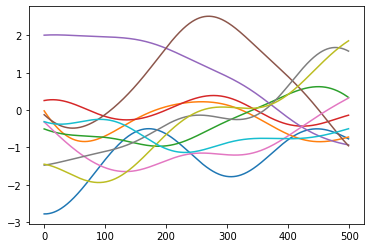

In [ ]:
dummy = plt.plot(np.transpose(y_train[:10,:]))
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def train_models(num_epochs, X): 
  methods = ['fourier', 'fpca', 'matern']
  latent_dims=10
  intermediate_dims=60
  lr=0.005
  batch_size=25

  models = {}
  histories = {}
  inversions = {}
  scalers = {}

  for method in methods:

    train_data = X

    if method == 'fpca':
      train_data = X - np.mean(X,axis=0)

    transformed_data, for_inversion, input_shape = transform_data(train_data, method=method) # could include more params like matern kernel params...
    # need to scale transformed data, so VAE loss is not NAN (does not tend to infinity from beginning on)
    # from experiments scaling to drastically leads to bad models once scaled back to original scale
    # scale so the maximal coefficient is roughly around 107 seems to work well for fft divide by 1000
    # or just use minmax scaler
    #if method == 'fourier':
     # scaled_transformed = transformed_data/1000 ###need to adjust for other data
    if np.max(np.abs(transformed_data)) <= 110:
      scaler = 1
    else:
      scaler = np.max(np.abs(transformed_data)) / 100 # scales maximum absolute value to be 100
    scaled_transformed = transformed_data / scaler
      #scaler = MinMaxScaler()
      #scaler.fit(transformed_data)
      #scaled_transformed = scaler.transform(transformed_data)
    scalers[method] = scaler

    model, hist, model_name = train_model(method, scaled_transformed, latent_dims, intermediate_dims, lr, num_epochs, batch_size)
    models[method] = model
    histories[method] = hist
    inversions[method] = for_inversion

  return models, histories, inversions, scalers

In [ ]:
models, histories, inversions, scalers = train_models(700, y_train)

Epoch 1/700
200/200 [==============================] - 1s 2ms/step - loss: 4.4122
Epoch 2/700
200/200 [==============================] - 0s 2ms/step - loss: 1.7218
Epoch 3/700
200/200 [==============================] - 0s 2ms/step - loss: 1.3649
Epoch 4/700
200/200 [==============================] - 0s 2ms/step - loss: 1.2210
Epoch 5/700
200/200 [==============================] - 0s 2ms/step - loss: 1.1123
Epoch 6/700
200/200 [==============================] - 0s 2ms/step - loss: 1.0655
Epoch 7/700
200/200 [==============================] - 0s 2ms/step - loss: 1.0266
Epoch 8/700
200/200 [==============================] - 0s 2ms/step - loss: 1.0098
Epoch 9/700
200/200 [==============================] - 0s 2ms/step - loss: 1.0072
Epoch 10/700
200/200 [==============================] - 0s 2ms/step - loss: 0.9929
Epoch 11/700
200/200 [==============================] - 0s 2ms/step - loss: 0.9962
Epoch 12/700
200/200 [==============================] - 0s 2ms/step - loss: 0.9836
Epoch 13/700


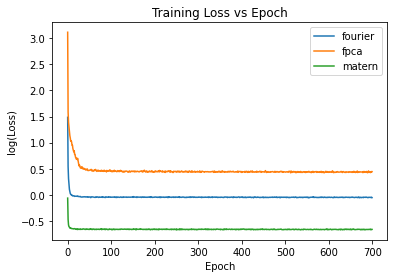

In [ ]:
methods = ['fourier', 'fpca', 'matern']
for method in methods:
  plt.plot(np.log(histories[method].history['loss']), label=method)
plt.xlabel('Epoch')
plt.ylabel('log(Loss)')
plt.title('Training Loss vs Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

def sample_plot(num_samples, models, inversions, scalers, methods, original):

  prior = tfd.Independent(tfd.Normal(loc=tf.zeros(10), scale=1), reinterpreted_batch_ndims=1)
  all_samples = {}
  for method in methods:
    latent_samples = prior.sample(num_samples)
    model = models[method]
    for_inversion = inversions[method]
    scaler = scalers[method]

    #decode with decoder
    decoded_samples = model.decoder(latent_samples)
    #reverse scaling
    decoded_samples_rescaled = invert_scaling(decoded_samples, scaler)
    #invert transform
    final_samples = invert_data(decoded_samples_rescaled, method, for_inversion)
    if method == 'fpca': # for fpca need to add mean back on
      final_samples = final_samples + np.mean(original, axis=0)
    all_samples[method] = final_samples

  fig, axs = plt.subplots(1, 4 , figsize=(20, 7))

  for i, ax in enumerate(fig.axes):
    if i>=len(methods):
      ax.plot(np.transpose(original), color='blue', alpha=20/original.shape[0], label='true data')
      ax.set_title('Original Data')
    else:
      ax.plot(np.transpose(all_samples[methods[i]]), color='blue', alpha=20/num_samples, label=methods[i])
      ax.set_title(methods[i])
    
  fig.suptitle('Samples for different Basis')
  plt.show()
  
  return all_samples

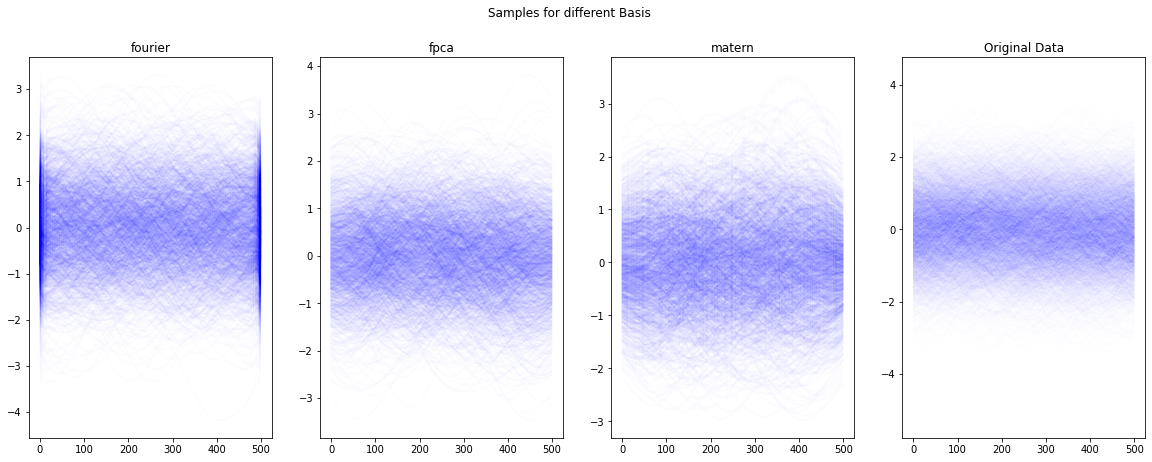

In [ ]:
original = y_train
all_samples = sample_plot(2000, models, inversions, scalers, methods, original)

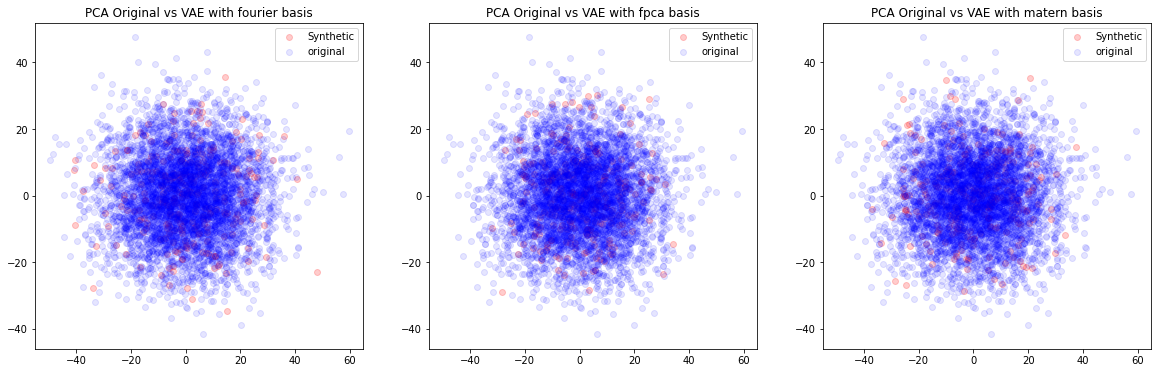

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca_dummy = PCA(n_components=2)
original_PCA = pca_dummy.fit_transform(original)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, ax in enumerate(fig.axes):
  pca_dummy = PCA(n_components=2)
  projected = pca_dummy.fit_transform(all_samples[methods[i]][:268,:])
  ax.scatter(projected[:,0], projected[:,1], color='red', label='Synthetic', alpha = 0.2)
  ax.scatter(original_PCA[:,0],original_PCA[:,1], color='blue', label = 'original', alpha=0.1)
  ax.set_title('PCA Original vs VAE with {} basis'.format(methods[i]))
  ax.legend(loc='upper right')

plt.show() 

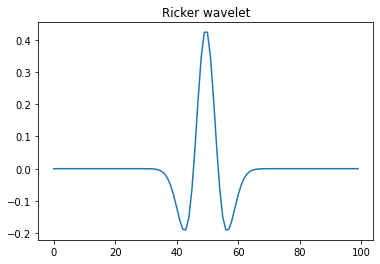

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
points = 100
a = 4.0
vec2 = signal.ricker(points, a)

plt.plot(vec2)
plt.title('Ricker wavelet')
plt.show()

## Comparison on spectra data

### Load Grid Data

In [100]:
file_name='./drive/My Drive/ThesisData/Gridwatch/processed_gridwatch.csv'
gridwatch = pd.read_csv(file_name)

In [101]:
dates = gridwatch.columns[1:] # extract dates

In [104]:
gridwatch.head()

timestamp  2011-11-13  2011-11-26  ...  2021-06-02  2021-06-07  2021-06-12
0   00:00:00       29452       32191  ...       21708       21637       21786
1   00:05:00       29592       31846  ...       21736       21605       21709
2   00:10:00       29701       31976  ...       21985       21603       21683
3   00:15:00       29756       32205  ...       22033       21505       21619
4   00:20:00       29755       32263  ...       21872       21504       21678

[5 rows x 533 columns]

In [102]:
dates = pd.to_datetime(dates, format='%Y-%m-%d') # convert to datetime object
weekdays = dates.weekday # get day of the week

In [103]:
day_labels = np.zeros((7,len(weekdays.values)))
for i in range(len(weekdays.values)):
  day_labels[weekdays.values[i], i] = 1

### Load Spectra Data

In [3]:
import glob
import pandas as pd
import numpy as np
file_dir='./drive/My Drive/ThesisData/Sugar_csv'
file_names = glob.glob('{}/wave*'.format(file_dir))

def get_sugar_data(file_names=file_names):
  data = map(pd.read_csv, file_names)
  data = [d.values for d in data]
  return np.stack(data, axis=2)

In [4]:
# load covariates and compute signature
sugar_spectra = get_sugar_data()

In [5]:
sugar_spectra = sugar_spectra[:,1:,:] # fist column is index, so remove
X_sugar = sugar_spectra[:,:-1,0] # extract one spectra at one frequency
# and removed last point, for simplicity with fourier transform (even)
original_sugar = X_sugar

In [16]:
from sklearn.preprocessing import MinMaxScaler
def train_models(training_data, methods, latent_dims=10, intermediate_dims=60, lr=0.005, num_epochs=2400, batch_size=25, max_after_scaling = 100): 
  #methods = ['fourier', 'fpca', 'matern']

  models = {}
  histories = {}
  inversions = {}
  scalers = {}

  for method in methods:

    train_data = training_data

    if method == 'fpca':
      train_data = training_data - np.mean(training_data,axis=0)

    transformed_data, for_inversion, input_shape = transform_data(train_data, method=method) # could include more params like matern kernel params...
    # need to scale transformed data, so VAE loss is not NAN (does not tend to infinity from beginning on)
    # from experiments scaling to drastically leads to bad models once scaled back to original scale
    # scale so the maximal coefficient is roughly around 107 seems to work well for fft divide by 1000
    # or just use minmax scaler
    #if method == 'fourier':
     # scaled_transformed = transformed_data/1000 ###need to adjust for other data
    if np.max(np.abs(transformed_data)) <= max_after_scaling:
      scaler = 1
      scaled_transformed = transformed_data
    if method =='cwt':
      max = np.max(transformed_data)
      min = np.min(transformed_data)
      scaled_transformed = (transformed_data - min) / (max - min)
      scaler = (max, min)
    else:
      scaler = np.max(np.abs(transformed_data)) / 100 # scales maximum absolute value to be 100
      scaled_transformed = transformed_data / scaler
      #scaler = MinMaxScaler()
      #scaler.fit(transformed_data)
      #scaled_transformed = scaler.transform(transformed_data)
    scalers[method] = scaler

    model, hist, model_name = train_model(method, scaled_transformed, latent_dims, intermediate_dims, lr, num_epochs, batch_size)
    models[method] = model
    histories[method] = hist
    inversions[method] = for_inversion

  return models, histories, inversions, scalers

In [ ]:
models, histories, inversions, scalers = train_models(X, latent_dims=10, intermediate_dims=100, lr=0.005, num_epochs=2400, batch_size=25, methods = ['fourier', 'fpca', 'matern'])

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
11/11 [==============================] - 0s 3ms/step - loss: 0.2829
Epoch 502/1000
11/11 [==============================] - 0s 3ms/step - loss: 0.2514
Epoch 503/1000
11/11 [==============================] - 0s 4ms/step - loss: 0.2768
Epoch 504/1000
11/11 [==============================] - 0s 3ms/step - loss: 0.2668
Epoch 505/1000
11/11 [==============================] - 0s 3ms/step - loss: 0.2644
Epoch 506/1000
11/11 [==============================] - 0s 3ms/step - loss: 0.2558
Epoch 507/1000
11/11 [==============================] - 0s 3ms/step - loss: 0.2672
Epoch 508/1000
11/11 [==============================] - 0s 4ms/step - loss: 0.2577
Epoch 509/1000
11/11 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 510/1000
11/11 [==============================] - 0s 3ms/step - loss: 0.3304
Epoch 511/1000
11/11 [==============================] - 0s 3ms/step - loss: 0.3762
Epoch 512/1000
11/11 [=============

In [ ]:
results = {}
results['spectra_small'] = (models, histories, inversions, scalers)

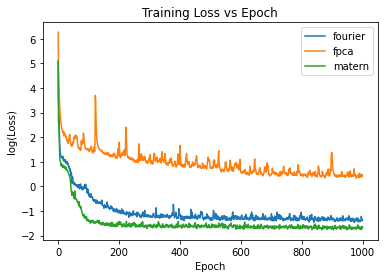

In [ ]:
methods = ['fourier', 'fpca', 'matern']
for method in methods:
  plt.plot(np.log(histories[method].history['loss']), label=method)
plt.xlabel('Epoch')
plt.ylabel('log(Loss)')
plt.title('Training Loss vs Epoch')
plt.legend(loc='upper right')
plt.show()

In [17]:
import tensorflow_probability as tfp
tfd = tfp.distributions

def sample_plot(num_samples, models, inversions, scalers, methods, original, latent_dims = 10):

  prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dims), scale=1), reinterpreted_batch_ndims=1)
  all_samples = {}
  for method in methods:
    latent_samples = prior.sample(num_samples)
    model = models[method]
    for_inversion = inversions[method]
    scaler = scalers[method]

    #decode with decoder
    decoded_samples = model.decoder(latent_samples)
    #reverse scaling
    decoded_samples_rescaled = invert_scaling(decoded_samples, scaler)
    #invert transform
    if method == 'dwt':
      decoded_samples_rescaled = decoded_samples_rescaled.numpy()
    final_samples = invert_data(decoded_samples_rescaled, method, for_inversion)
    if method == 'fpca': # for fpca need to add mean back on
      final_samples = final_samples + np.mean(original, axis=0)
    if method == 'cwt':
      ## potntially need to also center first
      final_samples = final_samples
    all_samples[method] = final_samples

  fig, axs = plt.subplots(1, len(methods)+1 , figsize=(20, 7))
  max = np.max(original)
  min = np.min(original)
  for i, ax in enumerate(fig.axes):
    if i>=len(methods):
      ax.plot(np.transpose(original), color='blue', alpha=20/original.shape[0], label='true data')
      ax.set_title('Original Data')
      ax.set_ylim([1.1*min,1.1*max])
    else:
      ax.plot(np.transpose(all_samples[methods[i]]), color='blue', alpha=20/num_samples, label=methods[i])
      ax.set_title(methods[i])
      ax.set_ylim([1.1*min,1.1*max])
    
  fig.suptitle('Samples for different Basis')
  plt.show()
  
  return all_samples

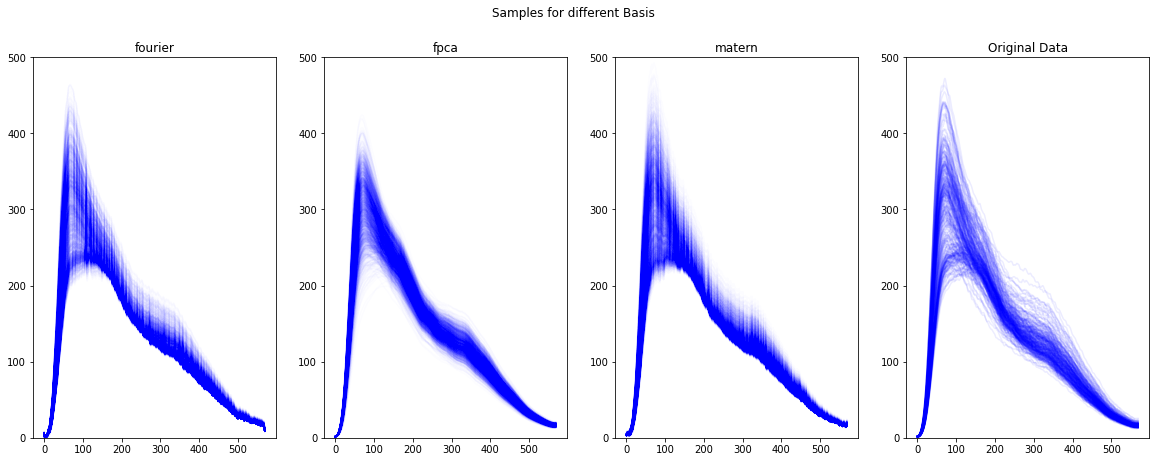

In [ ]:
all_samples = sample_plot(2000, models, inversions, scalers, methods, original)

In [ ]:
samples_datasets = {}
samples_datasets['spectra'] = all_samples

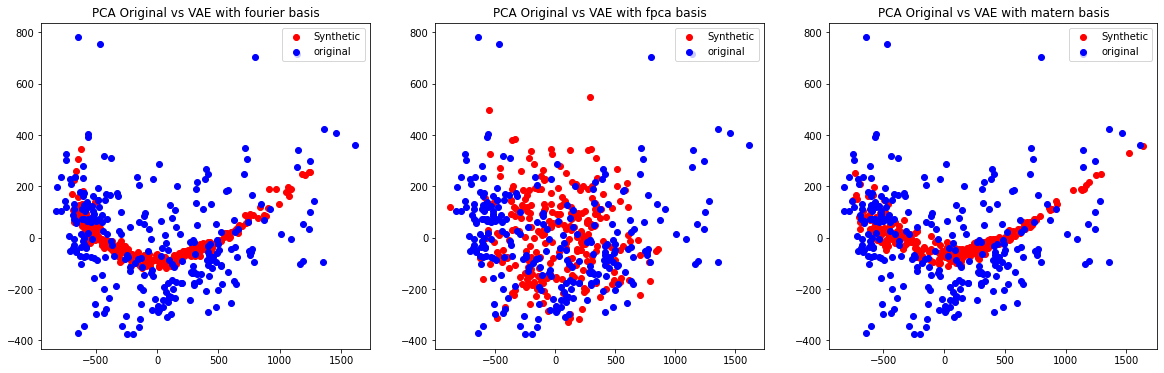

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca_dummy = PCA(n_components=2)
original_PCA = pca_dummy.fit_transform(original)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, ax in enumerate(fig.axes):
  #pca_dummy = PCA(n_components=2)
  projected = pca_dummy.transform(samples_datasets['spectra_small'][methods[i]][:268,:])
  ax.scatter(projected[:,0], projected[:,1], color='red', label='Synthetic')
  ax.scatter(original_PCA[:,0],original_PCA[:,1], color='blue', label = 'original')
  ax.set_title('PCA Original vs VAE with {} basis'.format(methods[i]))
  ax.legend(loc='upper right')

plt.show() 


In [60]:
all_samples = results['sugar'][0]
np.concatenate([X_sugar, all_samples['fourier'][:268,:]], axis=0).shape

(536, 570)

In [ ]:
for method in methods:
  gamma=-1
  mmd = MMD_K(K_SQR(original, all_samples[method]), original.shape[0], all_samples[method].shape[0])
  print('MMD between original data and {} samples with {} basis is: {}'.format(2000, method, mmd))

MMD between original data and 2000 samples with fourier basis is: 0.0
MMD between original data and 2000 samples with fpca basis is: 1.29e-320
MMD between original data and 2000 samples with matern basis is: 7.241226650500593e-158


In [18]:
def PCA_vis(all_samples, original, methods):

  # PCA dimensionality reduction and plot first 2 components
  pca_dummy = PCA(n_components=2)
  original_PCA = pca_dummy.fit_transform(original)

  fig, axs = plt.subplots(1, len(methods), figsize=(25, 6))

  for i, ax in enumerate(fig.axes):
    #pca_dummy = PCA(n_components=2)
    projected = pca_dummy.transform(all_samples[methods[i]][:268,:])
    ax.scatter(projected[:,0], projected[:,1], color='red', label='Synthetic')
    ax.scatter(original_PCA[:,0],original_PCA[:,1], color='blue', label = 'original')
    ax.set_title('PCA Original vs VAE with {} basis'.format(methods[i]))
    ax.legend(loc='upper right')

  plt.show() 

def TSNE_vis(all_samples, original, methods):
  num_original = original.shape[0]

  fig, axs = plt.subplots(1, len(methods), figsize=(25, 6))

  for i, ax in enumerate(fig.axes):
    TSNE_ = TSNE(n_components=2)
    projected = TSNE_.fit_transform(np.concatenate([original, all_samples[methods[i]][:num_original,:]], axis=0))
    ax.scatter(projected[num_original:,0], projected[num_original:,1], color='red', label='Synthetic')
    ax.scatter(projected[:num_original,0],projected[:num_original,1], color='blue', label = 'original')
    ax.set_title('t-SNE Original vs VAE with {} basis'.format(methods[i]))
    ax.legend(loc='upper right')

  plt.show() 

def train_and_analyse(data_set, data_name, validation_split=None, batch_size=25, num_samples=2000, num_epochs=1800, latent_dims = 5, methods = ['fourier', 'fpca', 'matern']):
  print('Performing training and analysis on {}'.format(data_name))
  original = data_set
  models, histories, inversions, scalers = train_models(data_set, latent_dims=latent_dims, intermediate_dims=100, lr=0.005, num_epochs=num_epochs, batch_size=batch_size, methods=methods)
  print('Training for all methods complete')
  # plot training loss
  for method in methods:
    if method == 'pca':
      plt.plot(np.log(histories[method].history['loss']), label=method)
    else: 
      plt.plot(np.log(histories[method].history['loss']), label=method)
  plt.xlabel('Epoch')
  plt.ylabel('log(Loss)')
  plt.title('Training Loss vs Epoch')
  plt.legend(loc='upper right')
  plt.show()
  
  print('Generating samples')
  # analyse data generation
  all_samples = sample_plot(num_samples, models, inversions, scalers, methods, data_set, latent_dims=latent_dims)
  # project samples and original into first two functional principal components and plot
  PCA_vis(all_samples, original, methods)
  # t-SNE and plot
  TSNE_vis(all_samples, original, methods)
  print('computing MMD')
  MMD_values = {}
  for method in methods:
    gamma=-1
    mmd = MMD_K(K_SQR(original, all_samples[method]), original.shape[0], all_samples[method].shape[0])
    print('MMD between original data and {} samples with {} basis is: {}'.format(2000, method, mmd))
    MMD_values[method] = mmd

  return all_samples, MMD_values, models, histories, inversions, scalers




Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
11/11 [==============================] - 0s 4ms/step - loss: 2.6218
Epoch 1102/1800
11/11 [==============================] - 0s 3ms/step - loss: 2.6418
Epoch 1103/1800
11/11 [==============================] - 0s 4ms/step - loss: 2.5867
Epoch 1104/1800
11/11 [==============================] - 0s 5ms/step - loss: 2.6503
Epoch 1105/1800
11/11 [==============================] - 0s 4ms/step - loss: 2.5716
Epoch 1106/1800
11/11 [==============================] - 0s 4ms/step - loss: 2.6152
Epoch 1107/1800
11/11 [==============================] - 0s 4ms/step - loss: 2.5294
Epoch 1108/1800
11/11 [==============================] - 0s 4ms/step - loss: 2.5807
Epoch 1109/1800
11/11 [==============================] - 0s 4ms/step - loss: 2.6561
Epoch 1110/1800
11/11 [==============================] - 0s 3ms/step - loss: 2.5033
Epoch 1111/1800
11/11 [==============================] - 0s 4ms/step - loss: 2.5425
Epoch 1112/1800
11/11 [==

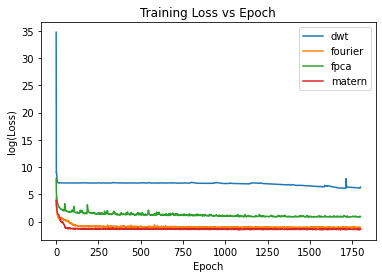

Generating samples


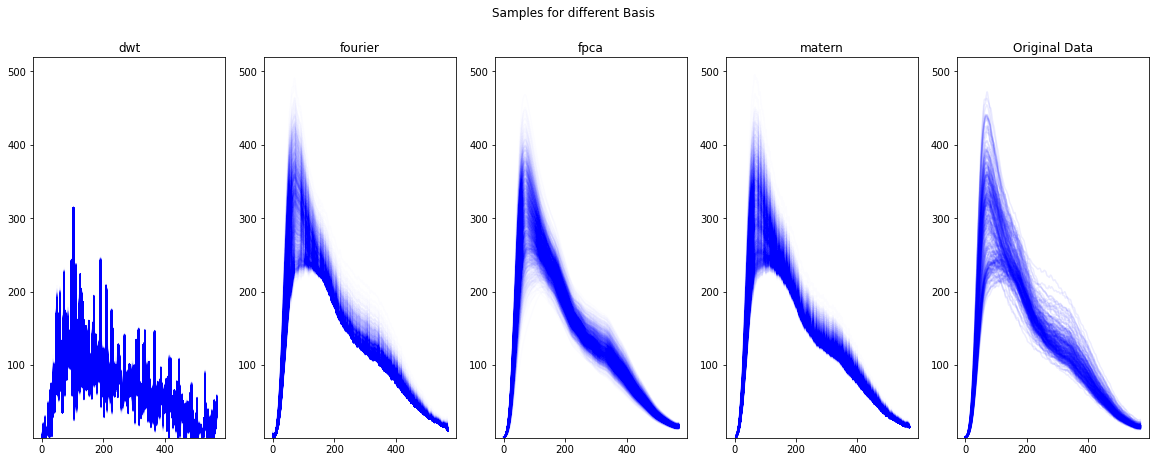

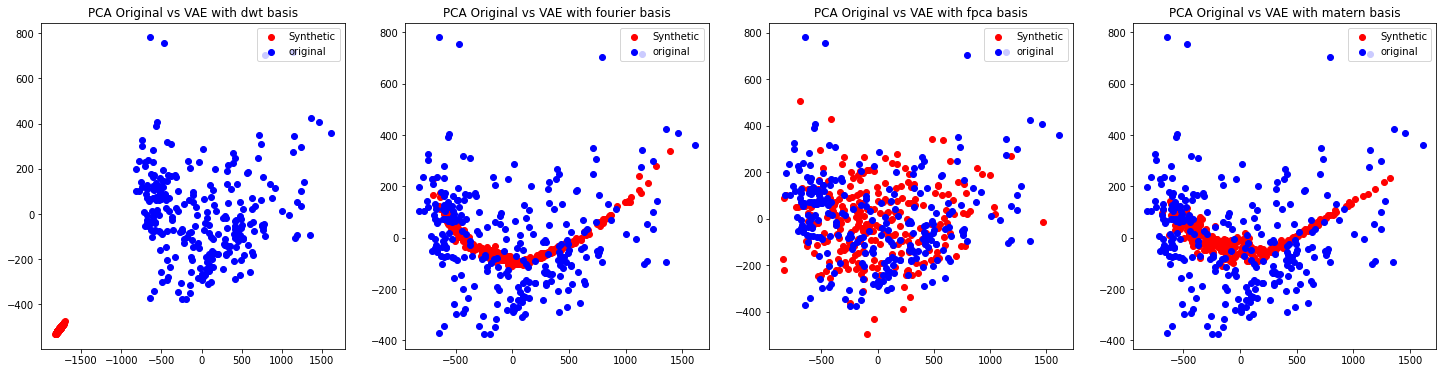

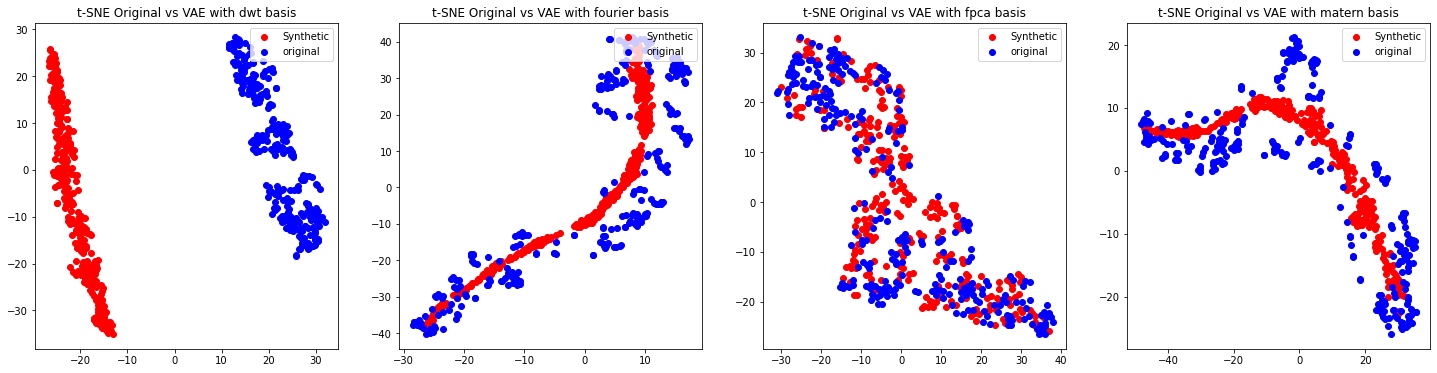

computing MMD
MMD between original data and 2000 samples with dwt basis is: 3.1608948465116207e-45
MMD between original data and 2000 samples with fourier basis is: 1.4105426056411997e-104
MMD between original data and 2000 samples with fpca basis is: 0.0
MMD between original data and 2000 samples with matern basis is: 5.025331533633528e-65


In [22]:
results = {}
# sugar data with dwt
#_, synthetic_data = sample_batch(260, 200, GP, 0, 200, x=1)
results['sugar'] = train_and_analyse(X_sugar, 'sugar', batch_size=25, num_samples=2000, num_epochs=1800, methods = ['dwt', 'fourier', 'fpca', 'matern'])

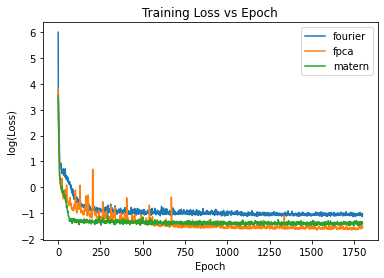

In [82]:
hist =  results['sugar'][3]
methods=['fourier', 'fpca', 'matern']
for method in methods:
  if method == 'fpca':
    plt.plot(np.log(hist[method].history['loss'])-2.5, label=method)
  else: 
    plt.plot(np.log(hist[method].history['loss']), label=method)
plt.xlabel('Epoch')
plt.ylabel('log(Loss)')
plt.title('Training Loss vs Epoch')
plt.legend(loc='upper right')
plt.show()

In [23]:
_, synthetic_data = sample_batch(2000, 100, GP, 0, 4 , x=1)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
14/14 [==============================] - 0s 4ms/step - loss: 2.8434
Epoch 1102/1800
14/14 [==============================] - 0s 4ms/step - loss: 2.8221
Epoch 1103/1800
14/14 [==============================] - 0s 4ms/step - loss: 2.8520
Epoch 1104/1800
14/14 [==============================] - 0s 4ms/step - loss: 2.8438
Epoch 1105/1800
14/14 [==============================] - 0s 4ms/step - loss: 2.8855
Epoch 1106/1800
14/14 [==============================] - 0s 4ms/step - loss: 2.8759
Epoch 1107/1800
14/14 [==============================] - 0s 4ms/step - loss: 2.8532
Epoch 1108/1800
14/14 [==============================] - 0s 4ms/step - loss: 2.8464
Epoch 1109/1800
14/14 [==============================] - 0s 5ms/step - loss: 2.8568
Epoch 1110/1800
14/14 [==============================] - 0s 3ms/step - loss: 2.8654
Epoch 1111/1800
14/14 [==============================] - 0s 4ms/step - loss: 2.8841
Epoch 1112/1800
14/14 [==

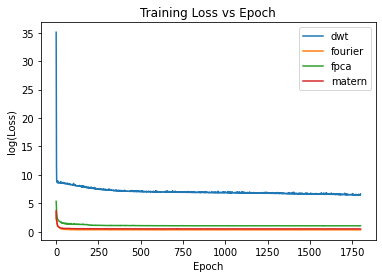

Generating samples


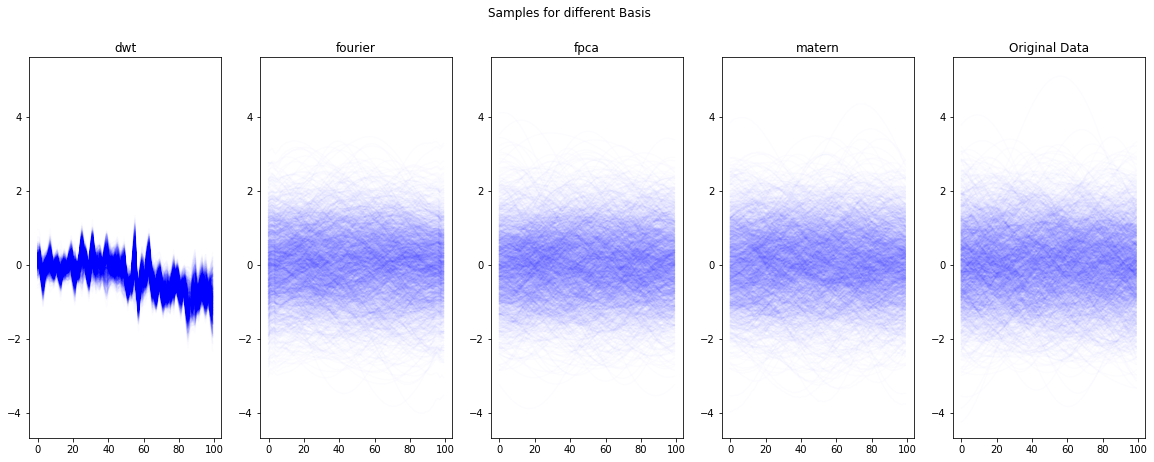

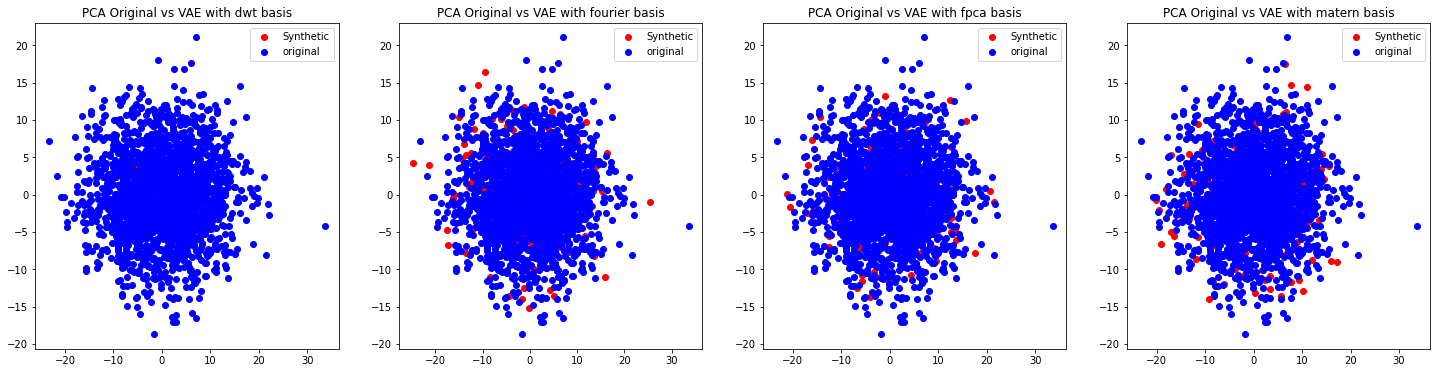

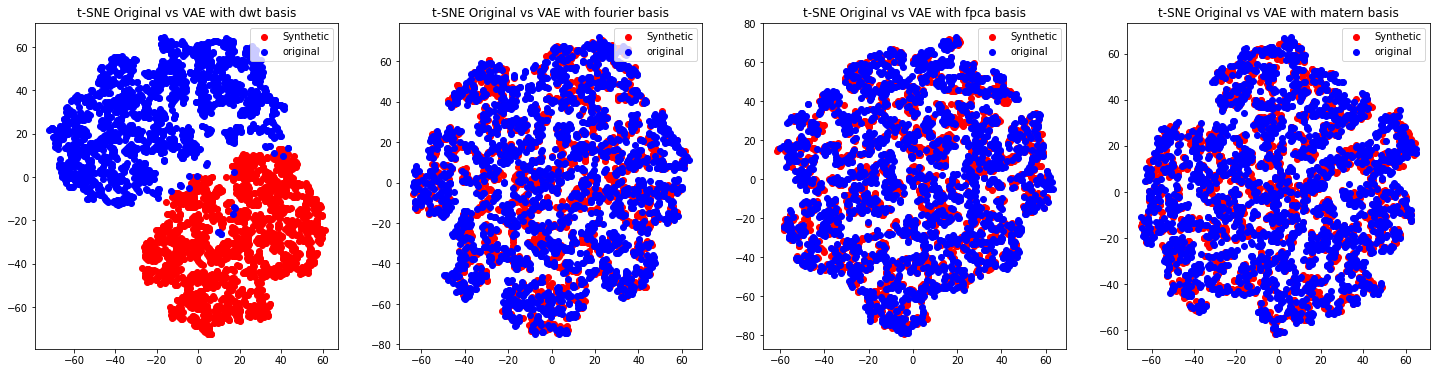

computing MMD
MMD between original data and 2000 samples with dwt basis is: 0.48754756170217495
MMD between original data and 2000 samples with fourier basis is: 0.004347467391275783
MMD between original data and 2000 samples with fpca basis is: 0.002370822795446731
MMD between original data and 2000 samples with matern basis is: 0.000955099928726888


In [30]:
results['synthetic'] = train_and_analyse(synthetic_data, 'synthetic', batch_size=150, num_samples=2000, num_epochs=1800, methods = ['dwt', 'fourier', 'fpca', 'matern'])

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
11/11 [==============================] - 0s 5ms/step - loss: 2.6975
Epoch 702/1600
11/11 [==============================] - 0s 6ms/step - loss: 2.7169
Epoch 703/1600
11/11 [==============================] - 0s 6ms/step - loss: 2.6340
Epoch 704/1600
11/11 [==============================] - 0s 5ms/step - loss: 2.5586
Epoch 705/1600
11/11 [==============================] - 0s 6ms/step - loss: 2.7972
Epoch 706/1600
11/11 [==============================] - 0s 6ms/step - loss: 3.0877
Epoch 707/1600
11/11 [==============================] - 0s 6ms/step - loss: 3.1326
Epoch 708/1600
11/11 [==============================] - 0s 6ms/step - loss: 4.3287
Epoch 709/1600
11/11 [==============================] - 0s 6ms/step - loss: 5.1346
Epoch 710/1600
11/11 [==============================] - 0s 6ms/step - loss: 3.4816
Epoch 711/1600
11/11 [==============================] - 0s 7ms/step - loss: 3.2099
Epoch 712/1600
11/11 [=============

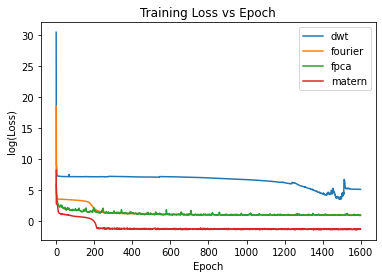

Generating samples


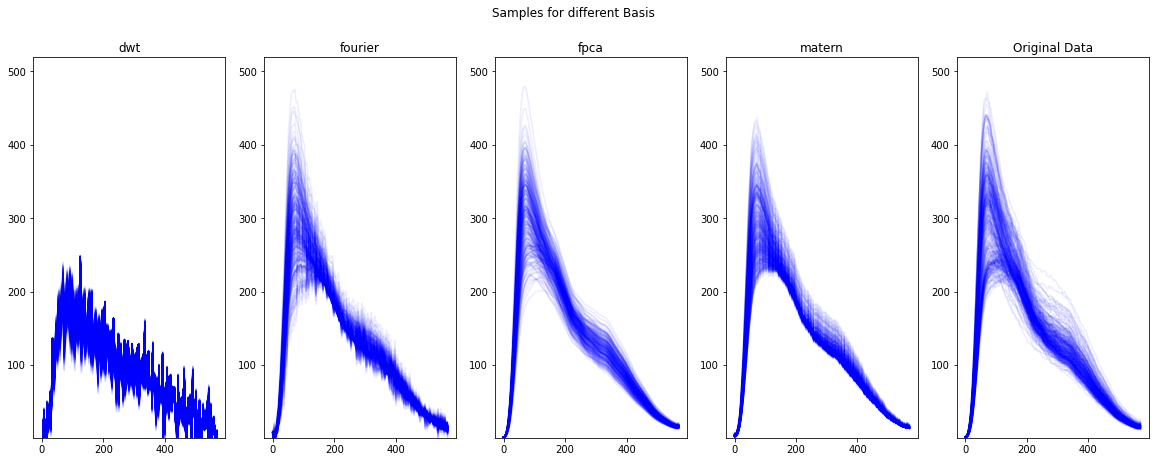

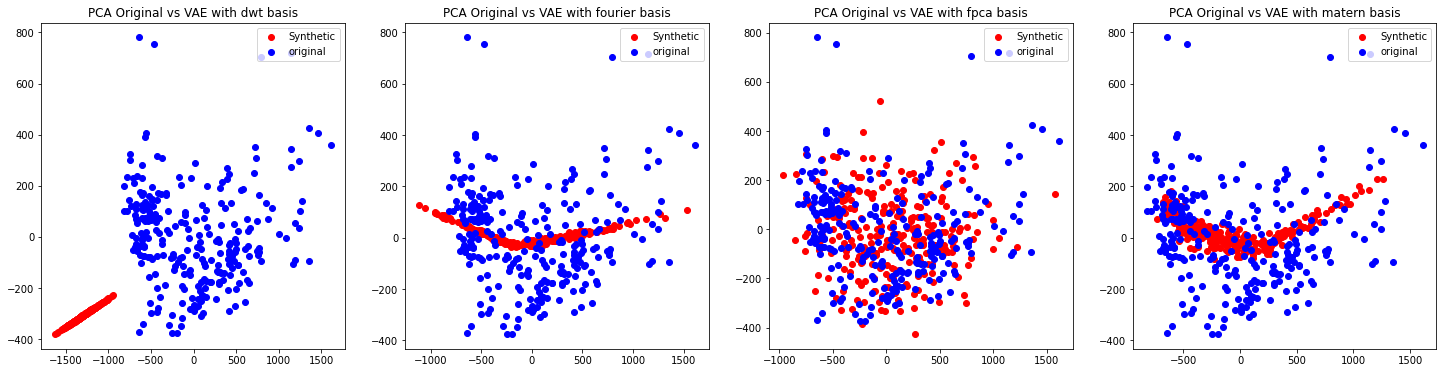

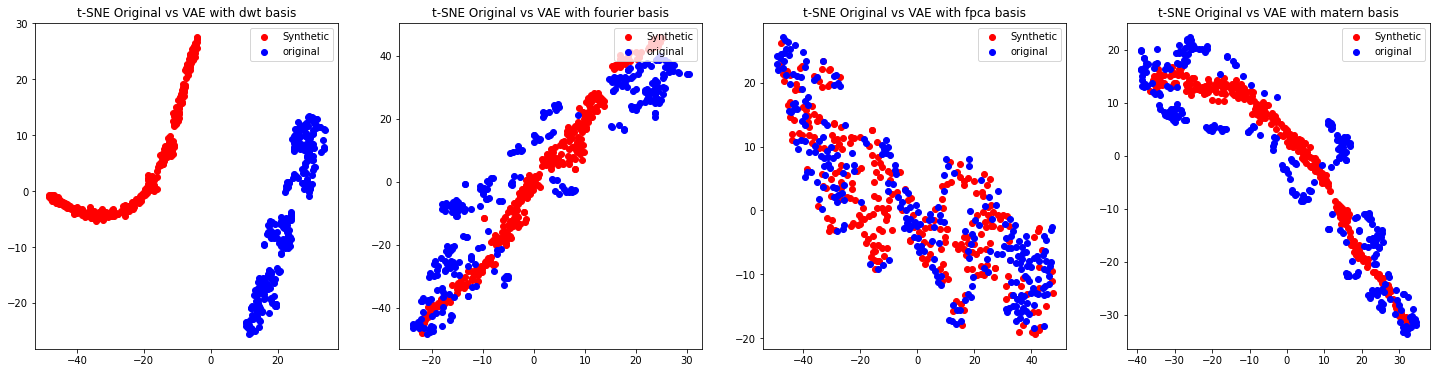

computing MMD
MMD between original data and 2000 samples with dwt basis is: 1.0805994703633232e-32
MMD between original data and 2000 samples with fourier basis is: 0.0
MMD between original data and 2000 samples with fpca basis is: 0.0
MMD between original data and 2000 samples with matern basis is: 0.0


In [190]:
results_dwt = {}
results_dwt['sugar'] = train_and_analyse(X_sugar, 'sugar', batch_size=25, num_samples=268, num_epochs=1600, methods = ['dwt','fourier', 'fpca', 'matern'])

In [108]:
# make train and test datasets
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras

data_sets = ['sugar', 'synthetic']

lstm_histories = {}
for data in data_sets:
  samples = results[data][0]
  if data == 'sugar':
    original = X_sugar
  else:
    original 
for method in methods:
  combined_data = np.concatenate([synthetic_data, all_samples[method][:2000,:]], axis=1)
  combined_data = np.expand_dims(combined_data, axis=-1)
  labels = np.concatenate([np.ones((synthetic_data.shape[0])), np.zeros((synthetic_data.shape[0]))])
  labels = np.expand_dims(labels, axis=-1)
  enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
  enc = enc.fit(labels)
  y_combined = enc.transform(labels)

  model_lstm = keras.Sequential()
  model_lstm.add(
      keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=20, 
            input_shape=[combined_data.shape[1], combined_data.shape[2]]
        )
      )
  )
  model_lstm.add(keras.layers.Dropout(rate=0.5))
  model_lstm.add(keras.layers.Dense(y_combined.shape[1], activation='softmax'))
  model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


  history = model_lstm.fit(
      combined_data, y_combined,
      epochs=1,
      batch_size=100,
      validation_split=0.5,
      shuffle=True
  )
  lstm_histories[method] = history


10/10 [==============================] - 11s 804ms/step - loss: 0.6643 - acc: 0.6080 - val_loss: 0.5285 - val_acc: 1.0000


In [20]:
# make train and test datasets
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras

synthetic_data= sample_batch(1000, 100, GP, 0, 4, x=1)[1]
synthetic_data = np.expand_dims(synthetic_data, axis=-1)
print(synthetic_data.shape)
synthetic_val= sample_batch(1000, 100, GP, 0, 4, x=1)[1]
synthetic_val = np.expand_dims(synthetic_val, axis=-1)

labels_data = np.random.choice([0,1], 1000)
labels_data = np.expand_dims(labels_data, -1)
labels_test = np.random.choice([0,1], 1000)
labels_test = np.expand_dims(labels_test, -1)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(labels_data)
labels_data = enc.transform(labels_data)
labels_test = enc.transform(labels_test)

model_lstm = keras.Sequential()
model_lstm.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=20, 
          input_shape=[synthetic_data.shape[1], synthetic_data.shape[2]]
      )
    )
)
model_lstm.add(keras.layers.Dropout(rate=0.5))
model_lstm.add(keras.layers.Dense(labels_data.shape[1], activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


history = model_lstm.fit(
    synthetic_data, labels_data, validation_data=None,
    epochs=1,
    batch_size=100,
    shuffle=True
)

(1000, 100, 1)
10/10 [==============================] - 5s 71ms/step - loss: 0.7009 - acc: 0.4850


### Sensitivity analysis Latent Dimension
Run models for latent dimension 2, ..., 20 and analyse resulting MMD

Epoch 1/700
11/11 [==============================] - 1s 2ms/step - loss: 34.1076
Epoch 2/700
11/11 [==============================] - 0s 2ms/step - loss: 32.6046
Epoch 3/700
11/11 [==============================] - 0s 2ms/step - loss: 27.4171
Epoch 4/700
11/11 [==============================] - 0s 2ms/step - loss: 20.0824
Epoch 5/700
11/11 [==============================] - 0s 2ms/step - loss: 12.8612
Epoch 6/700
11/11 [==============================] - 0s 3ms/step - loss: 8.1921
Epoch 7/700
11/11 [==============================] - 0s 2ms/step - loss: 5.3304
Epoch 8/700
11/11 [==============================] - 0s 2ms/step - loss: 3.8361
Epoch 9/700
11/11 [==============================] - 0s 3ms/step - loss: 3.4440
Epoch 10/700
11/11 [==============================] - 0s 2ms/step - loss: 3.1293
Epoch 11/700
11/11 [==============================] - 0s 2ms/step - loss: 3.3391
Epoch 12/700
11/11 [==============================] - 0s 2ms/step - loss: 2.7107
Epoch 13/700
11/11 [============

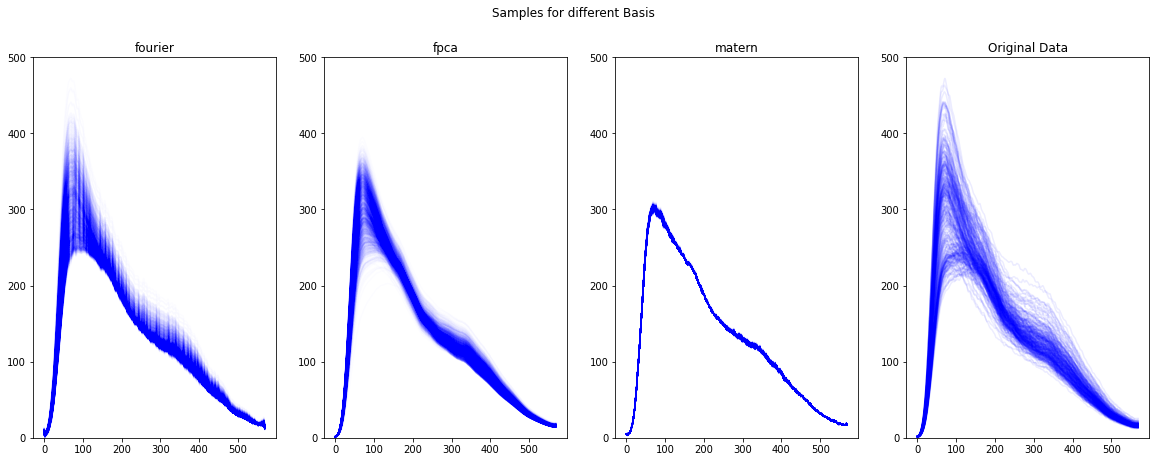

MMD between original data and 2000 samples with fourier basis and 2 latent dimensions is: 4.2876323805933723e-07
MMD between original data and 2000 samples with fpca basis and 2 latent dimensions is: 7.762131432893368e-08
MMD between original data and 2000 samples with matern basis and 2 latent dimensions is: 0.0009585987105735439
Epoch 1/700
11/11 [==============================] - 1s 3ms/step - loss: 33.6376
Epoch 2/700
11/11 [==============================] - 0s 3ms/step - loss: 29.8340
Epoch 3/700
11/11 [==============================] - 0s 4ms/step - loss: 23.9897
Epoch 4/700
11/11 [==============================] - 0s 4ms/step - loss: 15.0215
Epoch 5/700
11/11 [==============================] - 0s 3ms/step - loss: 7.4402
Epoch 6/700
11/11 [==============================] - 0s 3ms/step - loss: 4.4418
Epoch 7/700
11/11 [==============================] - 0s 5ms/step - loss: 3.3278
Epoch 8/700
11/11 [==============================] - 0s 4ms/step - loss: 2.6760
Epoch 9/700
11/11 [====

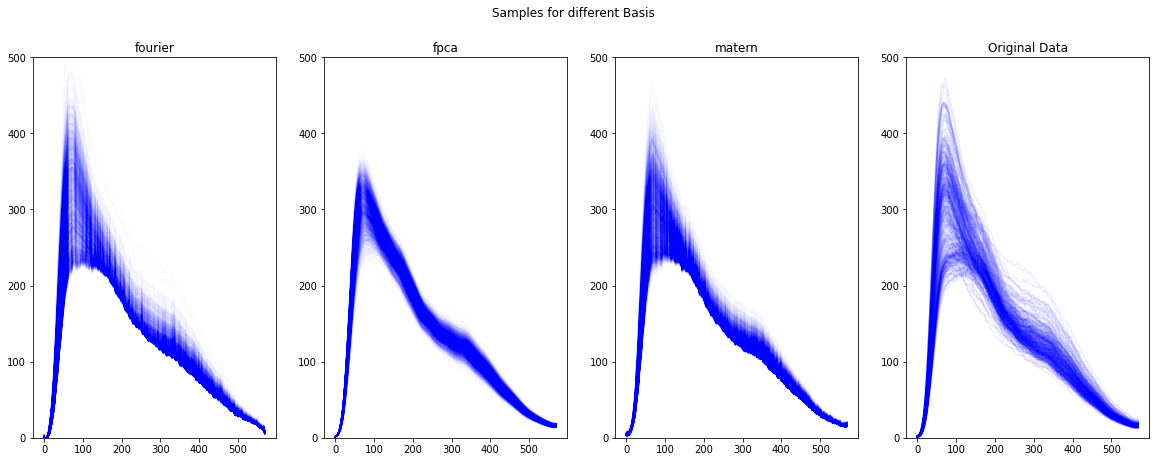

MMD between original data and 2000 samples with fourier basis and 5 latent dimensions is: 6.234502004130139e-148
MMD between original data and 2000 samples with fpca basis and 5 latent dimensions is: 0.0
MMD between original data and 2000 samples with matern basis and 5 latent dimensions is: 5.7487572872323684e-154
Epoch 1/700
11/11 [==============================] - 1s 4ms/step - loss: 1430049.1250
Epoch 2/700
11/11 [==============================] - 0s 3ms/step - loss: 49.8435
Epoch 3/700
11/11 [==============================] - 0s 3ms/step - loss: 36.9170
Epoch 4/700
11/11 [==============================] - 0s 4ms/step - loss: 32.6966
Epoch 5/700
11/11 [==============================] - 0s 3ms/step - loss: 32.1105
Epoch 6/700
11/11 [==============================] - 0s 4ms/step - loss: 31.8294
Epoch 7/700
11/11 [==============================] - 0s 4ms/step - loss: 31.4817
Epoch 8/700
11/11 [==============================] - 0s 3ms/step - loss: 31.2962
Epoch 9/700
11/11 [===========

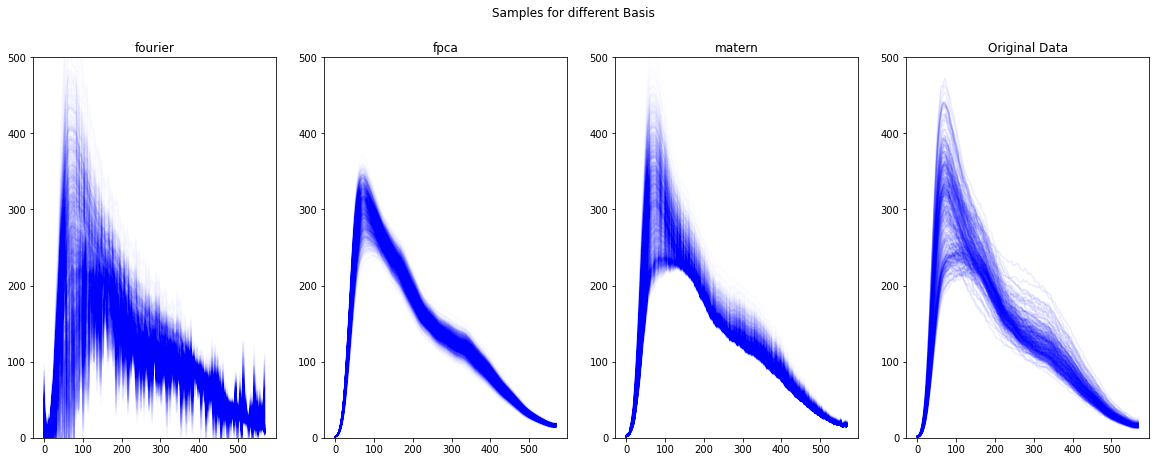

MMD between original data and 2000 samples with fourier basis and 10 latent dimensions is: 0.0
MMD between original data and 2000 samples with fpca basis and 10 latent dimensions is: 1.0270517600704648e-228
MMD between original data and 2000 samples with matern basis and 10 latent dimensions is: 0.0
Epoch 1/700
11/11 [==============================] - 1s 4ms/step - loss: 61.1529
Epoch 2/700
11/11 [==============================] - 0s 4ms/step - loss: 25.1722
Epoch 3/700
11/11 [==============================] - 0s 3ms/step - loss: 13.0651
Epoch 4/700
11/11 [==============================] - 0s 4ms/step - loss: 6.2010
Epoch 5/700
11/11 [==============================] - 0s 5ms/step - loss: 3.7919
Epoch 6/700
11/11 [==============================] - 0s 6ms/step - loss: 3.3632
Epoch 7/700
11/11 [==============================] - 0s 5ms/step - loss: 3.0400
Epoch 8/700
11/11 [==============================] - 0s 5ms/step - loss: 2.7224
Epoch 9/700
11/11 [==============================] - 0s 

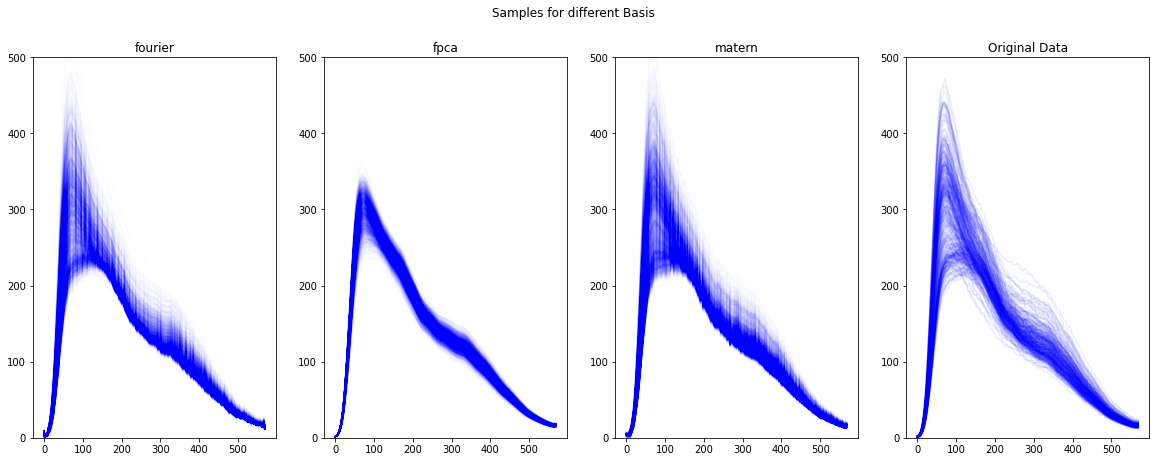

MMD between original data and 2000 samples with fourier basis and 15 latent dimensions is: 0.0
MMD between original data and 2000 samples with fpca basis and 15 latent dimensions is: 2.640086743918965e-299
MMD between original data and 2000 samples with matern basis and 15 latent dimensions is: 0.0
Epoch 1/700
11/11 [==============================] - 1s 5ms/step - loss: 66.1488
Epoch 2/700
11/11 [==============================] - 0s 5ms/step - loss: 25.7056
Epoch 3/700
11/11 [==============================] - 0s 5ms/step - loss: 13.5252
Epoch 4/700
11/11 [==============================] - 0s 6ms/step - loss: 5.9773
Epoch 5/700
11/11 [==============================] - 0s 5ms/step - loss: 3.4237
Epoch 6/700
11/11 [==============================] - 0s 6ms/step - loss: 2.6802
Epoch 7/700
11/11 [==============================] - 0s 7ms/step - loss: 2.4174
Epoch 8/700
11/11 [==============================] - 0s 5ms/step - loss: 2.3961
Epoch 9/700
11/11 [==============================] - 0s 5

In [ ]:
latent_dims = [2,5,10,15,20,30]
methods = ['fourier', 'fpca', 'matern']
mmd_dict = {}
for latent_dim in latent_dims:
  models, histories, inversions, scalers = train_models(X, latent_dims=latent_dim, intermediate_dims=100, lr=0.005, num_epochs=700, batch_size=25, methods = methods)
  all_samples = sample_plot(2000, models, inversions, scalers, methods, original, latent_dims=latent_dim)
  mmd_list=[]
  for method in methods:
    gamma=-1
    mmd = MMD_K(K_SQR(original, all_samples[method]), original.shape[0], all_samples[method].shape[0])
    mmd_list.append(mmd)
    print('MMD between original data and {} samples with {} basis and {} latent dimensions is: {}'.format(2000, method, latent_dim, mmd))
  mmd_dict[latent_dim] = mmd_list


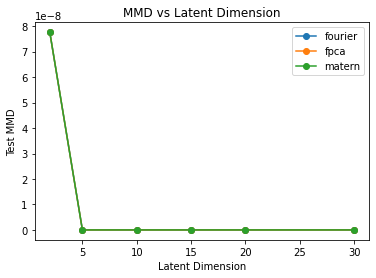

In [ ]:
for i in range(3):
  plt.plot(latent_dims, [mmd_dict[x][1] for x in latent_dims], '-o', label=methods[i])
plt.ylabel('Test MMD')
plt.xlabel('Latent Dimension')
plt.title('MMD vs Latent Dimension')
plt.legend()

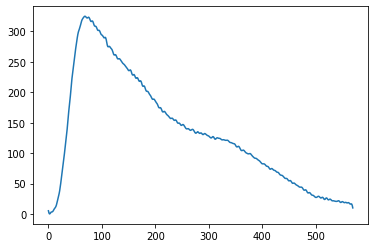

In [ ]:
hello = plt.plot(samples_datasets['spectra_small'][methods[0]][1000,:])

## CWT VAE on spectra data

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Reshape, UpSampling2D, Conv2DTranspose

In [ ]:
import glob
import pandas as pd
import numpy as np
file_dir='./drive/My Drive/ThesisData/Sugar_csv'
file_names = glob.glob('{}/wave*'.format(file_dir))

def get_sugar_data(file_names=file_names):
  data = map(pd.read_csv, file_names)
  data = [d.values for d in data]
  return np.stack(data, axis=2)

In [ ]:
# load covariates and compute signature
data = get_sugar_data()

In [112]:
#data = data[:,1:,:] # fist column is index, so remove
#X = data[:,:-1,0] # extract one spectra at one frequency
# and removed last point, for simplicity with fourier transform (even)
original = X_sugar

In [113]:
cwt_X = X_sugar[:,:496]- np.mean(X_sugar[:,:496], axis=0)

In [114]:
cwt_spectra, scales = cwt(cwt_X, dj=1/13, dt = 1)

In [115]:
cwt_spectra.shape

(268, 92, 496)

In [116]:
#cwt_spectra_sc = cwt_spectra/2000
#from sklearn.preprocessing import MinMaxScaler
max = np.max(cwt_spectra)
min = np.min(cwt_spectra)
cwt_spectra_sc = (cwt_spectra -min) /(max-min) 

#scaler = MinMaxScaler((0,1))
#scaler.fit(cwt_spectra)
#cwt_spectra_sc = scaler.transform(cwt_spectra)

In [117]:
cwt_spectra_sc = np.expand_dims(cwt_spectra_sc, -1)

In [ ]:


latent_size = 32
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(10), scale=1), reinterpreted_batch_ndims=1)
original_shape = (92,506,1)
encoder = Sequential([
      Conv2D(8, (5,5), activation='relu', padding='same', input_shape=original_shape),
      MaxPool2D((2,2)),
      Conv2D(8, (5,5), activation='relu', padding='same'),
      MaxPool2D((2,2)),
      Conv2D(8, (5,5), activation='relu', padding='same'),
      Flatten(),
      Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
      Dense(tfpl.IndependentNormal.params_size(latent_size)),
      tfpl.IndependentNormal(latent_size),
      tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10),
                              test_points_reduce_axis=None)
      ])

# Build the decoder
from tensorflow.keras.layers import Reshape, UpSampling2D, Conv2DTranspose


decoder = Sequential([
    Dense(72, activation='relu', input_shape=(latent_size,)),
    Reshape((3,8,3)),
    Conv2D(16, (5,5), activation='relu', padding='same'),
    Conv2DTranspose(8, (3,5), strides=3, activation='relu', output_padding=1),
    Conv2D(8, (5,5), activation='relu', padding='same'),
    Conv2DTranspose(8, (2,4), strides=3, activation='relu', output_padding=1),
    Conv2D(8, (4,4), activation='relu', padding='same'),
    Conv2DTranspose(8, (3,4), strides=3, activation='relu', output_padding=1),
    Conv2D(8, (5,5), activation='relu', padding='same'),
    Conv2DTranspose(8, (3,5), strides=2, activation='relu', output_padding=1),
    Conv2D(1,1, activation=None),
    Flatten(),
    tfpl.IndependentNormal(original_shape)
          ])

In [ ]:
decoder.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 60)                660       
_________________________________________________________________
dense_60 (Dense)             (None, 72)                4392      
_________________________________________________________________
reshape_14 (Reshape)         (None, 3, 8, 3)           0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 3, 8, 16)          1216      
_________________________________________________________________
conv2d_transpose_56 (Conv2DT (None, 10, 27, 8)         1928      
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 10, 27, 8)         1608      
_________________________________________________________________
conv2d_transpose_57 (Conv2DT (None, 30, 83, 8)       

In [ ]:

encoder = Sequential([
    Conv2D(8, (5,5), activation='relu', padding='same', input_shape=(28,28,1)),
    MaxPool2D((2,2)),
    Conv2D(8, (5,5), activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(8, (5,5), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(tfpl.IndependentNormal.params_size(latent_size)),
    tfpl.IndependentNormal(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10),
                            test_points_reduce_axis=None)
])

# Build the decoder

from tensorflow.keras.layers import Reshape, UpSampling2D, Conv2DTranspose
decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_size,)),
    Reshape((4,4,4)),
    Conv2D(16, (5,5), activation='relu', padding='same'),
    Conv2DTranspose(8, (5,5), strides=2, activation='relu', output_padding=1),
    Conv2D(8, (5,5), activation='relu', padding='same'),
    Conv2DTranspose(8, (3,3), activation='relu'),
    Conv2D(8, (5,5), activation='relu', padding='same'),
    Conv2DTranspose(8, (5,5), strides=2, activation='relu', output_padding=1),
    Conv2D(1,1, activation=None),
    Flatten(),
    tfpl.IndependentBernoulli((28,28,1))
          ])

In [ ]:
# Build end-to-end architecture
from tensorflow.keras.models import Model

cnn_vae = Model(inputs=encoder.inputs, outputs= decoder(encoder.outputs))



In [ ]:
# Define the reconstruction error loss
def reconstruction_loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)
cnn_vae.compile(optimizer='rmsprop', loss = reconstruction_loss)

history = cnn_vae.fit(cwt_spectra_sc, epochs=5)

Epoch 1/5
4/9 [============>.................] - ETA: 4s - loss: 0.6548

KeyboardInterrupt: ignored

In [ ]:
reconstruction_loss(cwt_spectra_sc[0,:,:], cnn_vae(cwt_spectra_sc[:1,:,:]))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([37476.285], dtype=float32)>

In [ ]:
# sample and invert for cnn_vae
num_samples =200
latent_samples = prior.sample(num_samples)
model = cnn_vae
for_inversion = scales


#decode with decoder
decoded_samples = decoder(latent_samples).mean()
#reverse scaling
decoded_samples_rescaled = decoded_samples*(max-min) + min
#invert transform
final_samples = invert_data(np.squeeze(decoded_samples_rescaled), 'cwt', for_inversion)

samples = final_samples

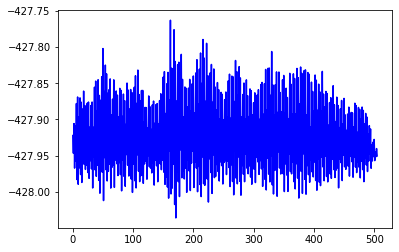

In [ ]:
sample_pl = plt.plot(samples[0,:], color='blue')

## written out implementation

In [109]:
# Build the VAE Model object
#
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean

loss_metric = Mean(name='loss')
kl_metric = Mean(name='kl')
nll_metric = Mean(name='nll')
class VAE_sgvb_full(Model):
    def __init__(self, encoder, decoder, prior, **kwargs):
        super(VAE_sgvb_full, self).__init__(inputs=encoder.inputs, outputs=decoder(encoder.outputs), **kwargs)
        self.prior = prior
        self.encoder = encoder
        self.decoder = decoder
        
    def _get_losses(self,data):
        approx_posterior = self.encoder(data)

        approx_posterior_sample = approx_posterior.sample()
        x_pred = self.decoder(approx_posterior_sample)
        nll_loss = -x_pred.log_prob(data)
        kl_loss = approx_posterior.log_prob(approx_posterior_sample) - self.prior.log_prob(approx_posterior_sample)
        loss = kl_loss + nll_loss
        return loss, kl_loss, nll_loss
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss, kl_loss, nll_loss = self._get_losses(data)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        loss_metric.update_state(loss)
        kl_metric.update_state(kl_loss)
        nll_metric.update_state(nll_loss)
        return {m.name:m.result() for m in self.metrics}
    def test_step(self, data):
        loss, kl_loss, nll_loss = self._get_losses(data)
        loss_metric.update_state(loss)
        kl_metric.update_state(kl_loss)
        nll_metric.update_state(nll_loss)
        return {m.name:m.result() for m in self.metrics}
    @property
    def metrics(self):
        return [loss_metric, kl_metric, nll_metric]

In [122]:

latent_size = 10
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(10), scale=1), reinterpreted_batch_ndims=1)
original_shape = (92,496,1)
encoder = Sequential([
      Conv2D(8, (5,5), activation='relu', padding='same', input_shape=original_shape),
      MaxPool2D((2,2)),
      Conv2D(8, (5,5), activation='relu', padding='same'),
      MaxPool2D((2,2)),
      Conv2D(8, (5,5), activation='relu', padding='same'),
      Flatten(),
      Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
      Dense(tfpl.IndependentNormal.params_size(latent_size)),
      tfpl.IndependentNormal(latent_size),
      ])

# Build the decoder
from tensorflow.keras.layers import Reshape, UpSampling2D, Conv2DTranspose


decoder = Sequential([
    Dense(153, activation='relu', input_shape=(latent_size,)),
    Reshape((3,17,3)),
    Conv2D(16, (4,5), activation='relu', padding='same'),
    Conv2DTranspose(8, (3,5), strides=3, activation='relu', output_padding=1),
    Conv2D(8, (5,5), activation='relu', padding='same'),
    Conv2DTranspose(8, (3,5), strides=3, activation='relu', output_padding=0),
    Conv2D(8, (3,4), activation='relu', padding='same'),
    Conv2DTranspose(8, (3,5), strides=3, activation='relu', output_padding=2),
    #Conv2D(8, (5,5), activation='relu', padding='same'),
    #Conv2DTranspose(8, (3,5), strides=2, activation='relu', output_padding=1),
    Conv2D(1,1, activation=None),
    Flatten(),
    tfpl.IndependentBernoulli(original_shape)
          ])


In [123]:
model = VAE_sgvb_full(encoder, decoder, prior)


In [124]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05))
history = model.fit(cwt_spectra_sc, epochs=50, batch_size=25
                    )

Epoch 1/50
11/11 [==============================] - 14s 1s/step - loss: 51589.5000 - kl: 19966.8672 - nll: 31622.6348
Epoch 2/50
11/11 [==============================] - 12s 1s/step - loss: 31616.9512 - kl: 0.2146 - nll: 31616.7344
Epoch 3/50
11/11 [==============================] - 12s 1s/step - loss: 31616.3320 - kl: 0.1288 - nll: 31616.2012
Epoch 4/50
11/11 [==============================] - 12s 1s/step - loss: 31616.0039 - kl: 0.0554 - nll: 31615.9473
Epoch 5/50
11/11 [==============================] - 13s 1s/step - loss: 31615.9590 - kl: 0.0374 - nll: 31615.9258
Epoch 6/50
11/11 [==============================] - 12s 1s/step - loss: 31616.0117 - kl: 0.0980 - nll: 31615.9141
Epoch 7/50
11/11 [==============================] - 12s 1s/step - loss: 31615.9844 - kl: 0.0752 - nll: 31615.9141
Epoch 8/50
11/11 [==============================] - 13s 1s/step - loss: 31615.9844 - kl: 0.0689 - nll: 31615.9141
Epoch 9/50
11/11 [==============================] - 12s 1s/step - loss: 31615.9629 -

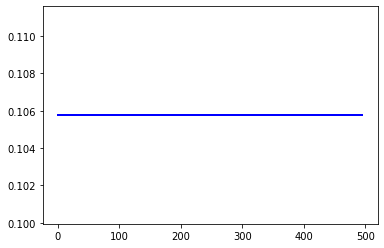

In [132]:
output = model(cwt_spectra_sc[:5,:,:]).mean()
decoded_samples_rescaled = output*(max-min) + min
for_inversion = scales
#invert transform
final_samples = invert_data(np.squeeze(decoded_samples_rescaled), 'cwt', for_inversion)

samples = final_samples

sample_pl = plt.plot(np.transpose(samples[:5,:]), color='blue')

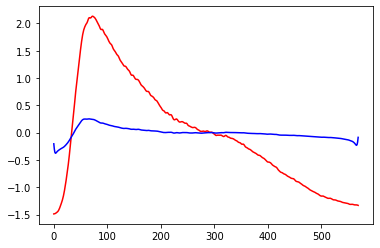

In [129]:
#transform, scales = cwt(cwt_X)
#inverted = invert_data(transform, 'cwt',scales)

dt = 1
dj = 1/13
mother = pycwt.MexicanHat()
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
J = 7 / dj  # number of powers of two with dj sub-octaves

n_scales = np.int(J+1)
signal = X_sugar[0,:] - np.mean(X_sugar[0,:])
sd = np.sqrt(np.var(signal))

signal = signal / sd
#first time save scales
wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(signal, dt, dj, s0, J, mother)
inverted = pycwt.icwt(wave, scales, dt, dj, mother)
plt.plot(signal, color='red')
plt.plot(inverted, color = 'blue')

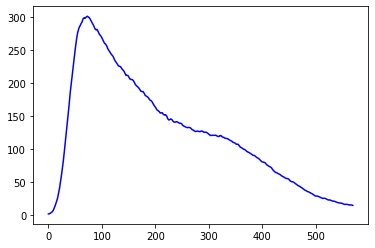

In [149]:
import pywt
x = X_sugar[:5,:]
cA, cD = pywt.dwt(x, 'db2')
inverted = pywt.idwt(cA[0,:], None, 'db2')
#plt.plot(np.transpose(x), color='red')
plt.plot(np.transpose(inverted), color='blue')

#y = X_sugar[10,:]
#cYA, cYD = pywt.dwt(y, 'db2')
#inverted_y = pywt.idwt(cYA, None, 'db2')
#plt.plot(y, color='red')
#plt.plot(inverted_y, color='blue')

In [148]:
cD.shape

(5, 286)

In [146]:
print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


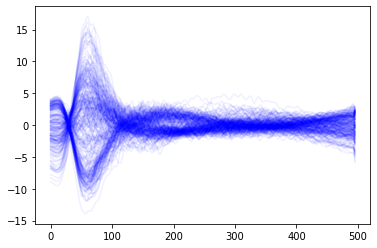

In [ ]:
test = plt.plot(np.transpose(inverted), color='blue', alpha=0.06)

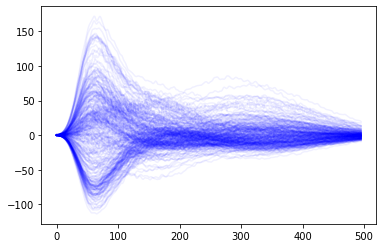

In [ ]:
test = plt.plot(np.transpose(cwt_X), color='blue', alpha=0.06)